# Requirements

In [94]:
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Optional, Tuple

%matplotlib inline

# Base Component Classs

The `CircuitComponent` class is the **foundation** for all other elements in your circuit library (Resistors, Capacitors, Sources, etc).

## Core Item and Purpose
|Feature|Explanation|Design Rationale|
|:-----:|:---------:|:--------------:|
|Base Class|This class is never meant to be instantiated directly. Instead, specific components (like `Resistor` or `Capacitor`) **inherit** from it.|Promotes code reusability and ensures all components share required properties (`id`, `value`, `nodes`).|
|Required Imports|The class relies on `uuid` (for unique IDs) and elements from `typing` (`Optional`, `List`, `Dict`, `Any`) for clear type hinting.|Essential for function (e.g. `uuid.uuid4()`) and crucial for code readability, debugging, and static analysis.|

## Input Parameters
|Parameter|Data Type|Purpose|
|:-------:|:-------:|:-----:|
|`value`|`float`|The physical value of the component (e.g. 100.0 Ohms, 5.0 Volts, 1e-6 Farads).|
|`name`|`str`|A unique, human-readable identifier (e.g. `R1`, `V_in`, `C_filter`)|
|`component_type`|`str`|A descriptive string of the component's kind (e.g. `Resistor`, `VoltageSource`). This is set automatically by the child classes.|
|`nodes`|`Optional[List[str]]`|A list of string names defining the connection points. `Optional` means it can be `None` (or an empty list `[]`) when first created.

In [95]:
class CircuitComponent:
    """The base class for all circuit elements."""
    def __init__(self, value: float, name: str, component_type: str, nodes: Optional[List[str]] = None):
        self.id: str = str(uuid.uuid4())
        self.value: float = value
        self.name: str = name
        self.component_type: str = component_type
        # Nodes list is now allowed to be empty initially
        self.nodes: List[str] = nodes if nodes is not None else []
        
    def __repr__(self) -> str:
        return (f"{self.name} ({self.component_type}) | Value: {self.value} | "
                f"Nodes: {self.nodes}")

    def get_properties(self) -> Dict[str, Any]:
        return {
            "id": self.id,
            "name": self.name,
            "type": self.component_type,
            "value": self.value,
            "nodes": self.nodes,
        }

# Specific Component Classes

In [96]:
class Resistor(CircuitComponent):
    """Represents a passive Resistor (R)."""
    def __init__(self, value: float, name: str, nodes: Optional[List[str]] = None):
        super().__init__(value, name, "Resistor", nodes)

class Capacitor(CircuitComponent):
    """Represents a passive Capacitor (C)."""
    def __init__(self, value: float, name: str, nodes: Optional[List[str]] = None):
        super().__init__(value, name, "Capacitor", nodes)

class Inductor(CircuitComponent):
    """Represents a passive Inductor (L)."""
    def __init__(self, value: float, name: str, nodes: Optional[List[str]] = None):
        super().__init__(value, name, "Inductor", nodes)

class VoltageSource(CircuitComponent):
    """Represents an active Voltage Source (V)."""
    def __init__(self, value: float, name: str, nodes: Optional[List[str]] = None):
        super().__init__(value, name, "VoltageSource", nodes)

# The Component Factory
The `ComponentFactory` class is not a circuit element itself, but it acts as a **creation service**. 
Its premary purpose is to simplify the process of instantiating specific component classes (`Resistor`, `Capacitor`, etc) and ensure they are created with standard convensions, like automatic naming.

## Core Design and Purpose
|Feature|Explanation|Design Rationale|
|:-----:|:---------:|:--------------:|
|Design Pattern|**Factory Pattern** - The class centralises the object creation logic, hiding the complexity (like generating unique IDs or default names) from the user.|Provides the clean and readable syntax you wanted: `createComps.resistor(...)`.|
|Static Methods|All creation methods (`resistor`, `capacitor`, etc.) are defined using `@staticmethod`.|This allows you to call the methods directly on the class (`ComponentFactory.resistor`) without ever needing to create an instance of the `ComponentFactory itself`.|
|Alias|The code suggests aliasing this class to `createComps`.|This provides a concise, user-friendly name for the creation functions.|

In [97]:
class ComponentFactory:
    """Factory for creating circuit components."""
    _resistor_counter = 0
    _capacitor_counter = 0
    _inductor_counter = 0 
    _source_counter = 0
    
    @staticmethod
    def _generate_name(prefix: str) -> str:
        """Internal helper to generate unique default names."""
        if prefix == 'R':
            ComponentFactory._resistor_counter += 1
            return f'R{ComponentFactory._resistor_counter}'
        elif prefix == 'C':
            ComponentFactory._capacitor_counter += 1
            return f'C{ComponentFactory._capacitor_counter}'
        elif prefix == 'L':
            ComponentFactory._inductor_counter += 1
            return f'L{ComponentFactory._inductor_counter}'
        elif prefix == 'V':
            ComponentFactory._source_counter += 1
            return f'V{ComponentFactory._source_counter}'
        return prefix

    @staticmethod
    def resistor(value: float, name: Optional[str] = None, nodes: Optional[List[str]] = None) -> Resistor:
        final_name = name if name is not None else ComponentFactory._generate_name('R')
        # NOTE: We allow nodes to be passed, but the new preferred workflow is to omit them
        # and use the circuit's connect_two_terminal method instead.
        return Resistor(value=value, name=final_name, nodes=nodes or [])

    @staticmethod
    def capacitor(value: float, name: Optional[str] = None, nodes: Optional[List[str]] = None) -> Capacitor:
        final_name = name if name is not None else ComponentFactory._generate_name('C')
        return Capacitor(value=value, name=final_name, nodes=nodes or [])

    @staticmethod
    def voltage_source(value: float, name: Optional[str] = None, nodes: Optional[List[str]] = None) -> VoltageSource:
        final_name = name if name is not None else ComponentFactory._generate_name('V')
        return VoltageSource(value=value, name=final_name, nodes=nodes or [])

    @staticmethod
    def inductor(value: float, name: Optional[str] = None, nodes: Optional[List[str]] = None) -> Inductor:
        final_name = name if name is not None else ComponentFactory._generate_name('L')
        return Inductor(value=value, name=final_name, nodes=nodes or [])

createComps = ComponentFactory

# Circuit

In [98]:
class Circuit:
    """
    Holds and manages all components for a specific circuit netlist, 
    and handles the process of wiring the components to nodes.
    """
    def __init__(self, name: str = "My Circuit"):
        self.name: str = name
        self.components: List[CircuitComponent] = []
        self.node_names: set = {'GND'} # Start with 'GND' node defined
        
    def connect_two_terminal(self, component: CircuitComponent, node_a: str, node_b: str):
        """
        Adds a 2-terminal component (R, L, C, V) to the circuit and 
        assigns its two connection nodes.
        """
        if component.nodes:
            print(f"Warning: Overwriting existing nodes for {component.name}.")
        
        # 1. Assign the nodes to the component object
        component.nodes = [node_a, node_b]
        
        # 2. Add the component to the circuit's master list
        self.components.append(component)
        
        # 3. Add node names to the master set of all nodes
        self.node_names.add(node_a)
        self.node_names.add(node_b)
            
        print(f"Connected {component.name} ({component.component_type}) between {node_a} and {node_b}.")


    def get_all_components(self) -> List[CircuitComponent]:
        """Returns the list of all components in the circuit."""
        return self.components

    def get_all_nodes(self) -> List[str]:
        """Returns a sorted list of unique node names (excluding GND)."""
        nodes_list = sorted(list(self.node_names))
        return [n for n in nodes_list if n != 'GND']

# Analysis

In [99]:
class CircuitAnalysis:
    """
    Performs the mathematical solution (MNA) and stores the results.
    """
    def __init__(self):
        self.node_map: Dict[str, int] = {} 
        self.source_map: Dict[str, int] = {} 
        self.nodes_list: List[str] = []
        
        # Transient Analysis History
        self.time_points: List[float] = []
        self.node_voltage_history: Dict[str, List[float]] = {}
        self.source_current_history: Dict[str, List[float]] = {}
        
        # DC Analysis Result
        self.solution_vector: Optional[np.ndarray] = None


    # --- Internal Solver Methods ---

    def _get_node_indices(self, nodes: List[str]) -> Tuple[int, int]:
        """Maps node names to MNA matrix indices."""
        n1, n2 = nodes[0], nodes[1]
        i = self.node_map.get(n1, -1)
        j = self.node_map.get(n2, -1)
        return i, j

    def _build_mna_matrices_dc(self, circuit: Circuit) -> Tuple[np.ndarray, np.ndarray]:
        """Helper to build MNA matrices for DC analysis (Capacitors open, Inductors shorted)."""
        self.nodes_list = circuit.get_all_nodes()
        N = len(self.nodes_list)
        
        voltage_sources = [c for c in circuit.components if c.component_type == "VoltageSource"]
        M = len(voltage_sources)
        size = N + M
        A = np.zeros((size, size))
        Z = np.zeros(size)
        
        for i, node in enumerate(self.nodes_list): self.node_map[node] = i
        self.node_map['GND'] = -1
        
        source_index = N 
        
        for comp in circuit.components:
            i, j = self._get_node_indices(comp.nodes)
            
            def add_to_A(r, c, val):
                if r != -1 and c != -1: A[r, c] += val
                
            if comp.component_type == "Resistor":
                G = 1.0 / comp.value
                add_to_A(i, i, G); add_to_A(j, j, G); add_to_A(i, j, -G); add_to_A(j, i, -G)
                
            elif comp.component_type == "VoltageSource":
                k = source_index
                self.source_map[comp.id] = k
                
                if i != -1: A[k, i] = 1.0; A[i, k] = 1.0
                if j != -1: A[k, j] = -1.0; A[j, k] = -1.0
                
                Z[k] = comp.value
                source_index += 1
                
            elif comp.component_type == "Inductor":
                # Inductor is a short circuit in DC: treat as very low resistance
                R_approx = 1e-9
                G = 1.0 / R_approx
                add_to_A(i, i, G); add_to_A(j, j, G); add_to_A(i, j, -G); add_to_A(j, i, -G)
            
            # Capacitors are ignored (open circuit) in DC analysis.
        
        return A, Z

    def _build_mna_matrices_transient(self, circuit: Circuit, dt: float, prev_V: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Helper to build MNA matrices for Transient analysis using Backward Euler.
        (Solves for V(t) based on V(t-dt)).
        """
        self.nodes_list = circuit.get_all_nodes()
        N = len(self.nodes_list)
        
        # Reset node mapping for safety
        self.node_map = {node: i for i, node in enumerate(self.nodes_list)}
        self.node_map['GND'] = -1
        
        # Find MNA expansion components (V sources and Inductors)
        mna_expand_comps = [c for c in circuit.components if c.component_type in ["VoltageSource", "Inductor"]]
        M = len(mna_expand_comps) 
        
        size = N + M
        A = np.zeros((size, size))
        Z = np.zeros(size)
        
        # Map source/inductor ID to their auxiliary current index (starting at N)
        self.source_map = {}
        source_index = N
        for comp in mna_expand_comps:
            self.source_map[comp.id] = source_index
            source_index += 1
        
        # Helper to place stamp components in the matrix
        def add_to_A(r, c, val):
            if r != -1 and c != -1: A[r, c] += val

        # MNA Stamping loop
        for comp in circuit.components:
            i, j = self._get_node_indices(comp.nodes)
            
            # Helper to get previous node voltage V(t-dt)
            def get_prev_V(node_index):
                return prev_V[node_index] if node_index != -1 else 0.0

            # 1. Resistor Stamp (G=1/R)
            if comp.component_type == "Resistor":
                G = 1.0 / comp.value
                add_to_A(i, i, G); add_to_A(j, j, G); add_to_A(i, j, -G); add_to_A(j, i, -G)
                
            # 2. Capacitor Stamp (Uses Conductance G_eq = C/dt)
            elif comp.component_type == "Capacitor":
                G_eq = comp.value / dt
                V_prev = get_prev_V(i) - get_prev_V(j) # Vc(t-dt) = V_i(t-dt) - V_j(t-dt)
                I_eq = G_eq * V_prev # Equivalent current source for Backward Euler
                
                # Conductance Stamp
                add_to_A(i, i, G_eq); add_to_A(j, j, G_eq); add_to_A(i, j, -G_eq); add_to_A(j, i, -G_eq)
                
                # Current Source Stamp
                if i != -1: Z[i] -= I_eq
                if j != -1: Z[j] += I_eq

            # 3. Inductor Stamp (Uses Resistance R_eq = L/dt)
            elif comp.component_type == "Inductor":
                k = self.source_map[comp.id] # Auxiliary variable is current through inductor
                R_eq = comp.value / dt
                
                # MNA Equations
                if i != -1: A[k, i] = -1.0; A[i, k] = -1.0 # Equation for V_i
                if j != -1: A[k, j] = 1.0; A[j, k] = 1.0 # Equation for V_j

                # I_L(t) - I_L(t-dt) = (1/R_eq) * (V_i(t) - V_j(t))
                A[k, k] = R_eq # R_eq on the diagonal
                
                # Current source (I_L(t-dt) * R_eq) from previous time step
                Z[k] = R_eq * prev_V[k]

            # 4. Voltage Source Stamp
            elif comp.component_type == "VoltageSource":
                k = self.source_map[comp.id]
                
                if i != -1: A[k, i] = 1.0; A[i, k] = 1.0
                if j != -1: A[k, j] = -1.0; A[j, k] = -1.0
                
                Z[k] = comp.value

        return A, Z
        
    # --- Public Analysis Methods ---

    def solve_dc(self, circuit: Circuit):
        """Solves the circuit for DC operating points."""
        A, Z = self._build_mna_matrices_dc(circuit)
        
        try:
            self.solution_vector = np.linalg.solve(A, Z)
            print("\nSuccessfully solved the DC operating point.")
        except np.linalg.LinAlgError as e:
            print(f"\n--- ERROR: DC Matrix solution failed ---")
            self.solution_vector = None

    def solve_transient(self, circuit: Circuit, time_end: float, dt: float):
        """
        Solves the circuit's dynamic behavior over time using Backward Euler.
        """
        # Initial conditions and history reset
        self.time_points = []
        self.node_voltage_history = {node: [] for node in circuit.get_all_nodes()}
        
        # Initial MNA setup to get the size for the history array
        # We use a dummy prev_V of zeros for the very first step
        dummy_prev_V = np.zeros(len(circuit.get_all_nodes()) + len([c for c in circuit.components if c.component_type in ["VoltageSource", "Inductor"]]))
        A, Z = self._build_mna_matrices_transient(circuit, dt, dummy_prev_V)
        
        size = A.shape[0]
        # prev_V contains all solved variables (Voltages + Aux Currents)
        prev_V = np.zeros(size) 
        
        # Map source/inductor IDs to their auxiliary current index
        current_map = {comp_id: index for comp_id, index in self.source_map.items()}
        self.source_current_history = {comp_id: [] for comp_id in current_map}

        
        # Start the transient simulation loop
        current_time = 0.0
        while current_time <= time_end:
            # 1. Build Matrices A(t) and Z(t) based on previous state V(t-dt)
            A, Z = self._build_mna_matrices_transient(circuit, dt, prev_V)

            try:
                # 2. Solve for current state V(t)
                V_current = np.linalg.solve(A, Z)
            except np.linalg.LinAlgError:
                print(f"ERROR: Matrix singularity at time t={current_time:.6f}s.")
                break

            # 3. Store Results
            self.time_points.append(current_time)
            
            # Store Node Voltages
            for node_name, index in self.node_map.items():
                if node_name != 'GND':
                    self.node_voltage_history[node_name].append(V_current[index])
            
            # Store Auxiliary Currents (Source and Inductor Current)
            for comp_id, index in current_map.items():
                 self.source_current_history[comp_id].append(V_current[index])

            # 4. Prepare for next step
            prev_V = V_current
            current_time += dt
            
        print(f"\nTransient analysis complete. {len(self.time_points)} steps simulated.")


    # --- Public Measurement and Display Methods ---

    def get_voltage(self, node_name: str) -> float:
        """Returns the DC voltage at a single node relative to Ground (GND)."""
        if self.solution_vector is None or node_name == 'GND': return 0.0
        if node_name not in self.node_map: return 0.0
        
        index = self.node_map[node_name]
        return float(self.solution_vector[index]) if index < len(self.nodes_list) else 0.0

    
    def voltage_difference(self, node_a: str, node_b: str) -> float:
        """Calculates the DC potential difference V(A) - V(B)."""
        return self.get_voltage(node_a) - self.get_voltage(node_b)
        
    def get_component_current(self, component: CircuitComponent) -> float:
        """
        Calculates the DC current through a component (Positive current flows from node 1 to node 2).
        """
        if self.solution_vector is None: return 0.0

        n1, n2 = component.nodes[0], component.nodes[1]
        
        if component.component_type == "VoltageSource" or component.component_type == "Inductor":
            if component.id in self.source_map:
                k = self.source_map[component.id]
                return float(self.solution_vector[k])
        
        elif component.component_type == "Resistor":
            v_diff = self.voltage_difference(n1, n2)
            return v_diff / component.value

        # In DC analysis, Capacitor current is 0. Inductor current solved for by MNA is not
        # stored in self.solution_vector outside of the transient solver.
        return 0.0
    
    def display_results(self, circuit: Circuit) -> pd.DataFrame:
        """Returns a summary table of all components, their voltages, and currents using a Pandas DataFrame."""
        if self.solution_vector is None:
            print("\nCannot display results. Run solve_dc() first.")
            return pd.DataFrame() # Return empty DataFrame if solution is missing

        data = []
        
        for comp in circuit.get_all_components():
            v_a = self.get_voltage(comp.nodes[0])
            v_b = self.get_voltage(comp.nodes[1])
            v_diff = v_a - v_b 
            current = self.get_component_current(comp)
            
            data.append({
                "Name": comp.name,
                "Type": comp.component_type,
                "Value": comp.value,
                "Nodes": f"{comp.nodes[0]}-{comp.nodes[1]}",
                "Voltage (V)": v_diff,
                "Current (A)": current,
            })
            
        df = pd.DataFrame(data)
        
        print("\n--- DC Analysis Component Results ---")
        
        # Return the DataFrame, allowing the Jupyter environment to render the HTML table
        return df


    # --- Plotting Methods ---
    
    @staticmethod
    def _plot_setup(time_points, data, title, ylabel, label):
        """Helper for standard plot generation."""
        plt.figure(figsize=(10, 5))
        plt.plot(time_points, data, label=label)
        plt.title(title)
        plt.xlabel("Time (s)")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_voltage_difference(self, node_a: str, node_b: str, title: str = "Voltage Difference vs. Time"):
        """
        Plots the voltage difference V(A) - V(B) over the simulated time.
        """
        if not self.time_points:
            print("Error: No transient data available. Run solve_transient() first.")
            return

        V_a = self.node_voltage_history.get(node_a, [0.0] * len(self.time_points))
        V_b = self.node_voltage_history.get(node_b, [0.0] * len(self.time_points))
        
        # Calculate V_a - V_b
        V_diff = np.array(V_a) - np.array(V_b)
        
        self._plot_setup(
            self.time_points, 
            V_diff, 
            title, 
            "Voltage (V)", 
            f'V({node_a}) - V({node_b})'
        )

    def plot_component_current(self, circuit: Circuit, comp_name: str):
        """
        Plots the current through a specific component over the simulated time.
        """
        if not self.time_points:
            print("Error: No transient data available. Run solve_transient() first.")
            return
            
        component = next((c for c in circuit.components if c.name == comp_name), None)
        if not component:
            print(f"Error: Component '{comp_name}' not found in the circuit.")
            return

        current_data = None
        
        # 1. Voltage Source or Inductor (Current is an MNA auxiliary variable)
        if component.component_type in ["VoltageSource", "Inductor"]:
            if component.id in self.source_current_history:
                current_data = self.source_current_history[component.id]
        
        # 2. Resistor or Capacitor (Current derived from node voltages)
        elif component.component_type in ["Resistor", "Capacitor"]:
            n1, n2 = component.nodes[0], component.nodes[1]
            V_n1 = self.node_voltage_history.get(n1, [0.0] * len(self.time_points))
            V_n2 = self.node_voltage_history.get(n2, [0.0] * len(self.time_points))
            V_diff = np.array(V_n1) - np.array(V_n2)
            
            if component.component_type == "Resistor":
                current_data = V_diff / component.value # I = V/R
            
            elif component.component_type == "Capacitor":
                # I = C * dV/dt (Approximate derivative using central difference)
                C = component.value
                # Calculate time difference array
                dt_array = np.diff(self.time_points)
                # Calculate voltage difference array
                dV_array = np.diff(V_diff) 
                
                # Use a small epsilon to prevent division by zero in case of constant time steps
                dt_safe = dt_array + np.finfo(float).eps
                dV_dt = dV_array / dt_safe
                I_cap = C * dV_dt
                
                # Pad current data to match time steps (since diff loses one point)
                current_data = np.insert(I_cap, 0, I_cap[0] if I_cap.size > 0 else 0.0) 

        if current_data is None:
            print(f"Error: Current calculation not yet supported for transient {component.component_type}.")
            return
            
        self._plot_setup(
            self.time_points, 
            current_data, 
            f"Current Through {comp_name} vs. Time", 
            "Current (A)", 
            f'I({comp_name})'
        )

# Test Usage

In [ ]:
# BLOCK 1: Creating Components for a DC Voltage Divider
print("\n=== BLOCK 1: Creating DC Components ===")
V_dc = createComps.voltage_source(value=10.0, name="V_DC")
R_top = createComps.resistor(value=100.0, name="R_top")
R_bot = createComps.resistor(value=100.0, name="R_bot")


=== BLOCK 1: Creating DC Components ===


In [ ]:
# BLOCK 2: Connecting Nodes for the Voltage Divider
print("\n=== BLOCK 2: Connecting DC Nodes ===")
dc_circuit = Circuit(name="Voltage Divider")
dc_circuit.connect_two_terminal(V_dc, 'N_input', 'GND')
dc_circuit.connect_two_terminal(R_top, 'N_input', 'N_mid')
dc_circuit.connect_two_terminal(R_bot, 'N_mid', 'GND')


=== BLOCK 2: Connecting DC Nodes ===
Connected V_DC (VoltageSource) between N_input and GND.
Connected R_top (Resistor) between N_input and N_mid.
Connected R_bot (Resistor) between N_mid and GND.


In [108]:
# BLOCK 3: DC Analysis and Table Display
print("\n=== BLOCK 3: DC Analysis Results ===")
dc_analysis = CircuitAnalysis()
dc_analysis.solve_dc(dc_circuit)
dc_results_df = dc_analysis.display_results(dc_circuit)

dc_results_df 


=== BLOCK 3: DC Analysis Results ===

Successfully solved the DC operating point.

--- DC Analysis Component Results ---


,Name,Type,Value,Nodes,Voltage (V),Current (A)
0,V_DC,VoltageSource,10.0,N_input-GND,10.0,-0.05
1,R_top,Resistor,100.0,N_input-N_mid,5.0,0.05
2,R_bot,Resistor,100.0,N_mid-GND,5.0,0.05


In [103]:
# BLOCK 4: DC Value Check (Voltage at the mid node)
print("\n=== BLOCK 4: DC Voltage Check ===")
V_mid_dc = dc_analysis.get_voltage('N_mid')
print(f"Calculated DC Voltage at N_mid (V_out): {V_mid_dc:.2f} V")
# Expected value for 10V / (100+100) * 100 = 5.0 V


=== BLOCK 4: DC Voltage Check ===
Calculated DC Voltage at N_mid (V_out): 5.00 V


In [104]:
# BLOCK 5: RLC Component Creation
print("\n=== BLOCK 5: Creating RLC Components ===")
V_step = createComps.voltage_source(value=10.0, name="V_step")
R_rlc = createComps.resistor(value=100.0, name="R_rlc") 
L1 = createComps.inductor(value=1e-3, name="L1") 
C1 = createComps.capacitor(value=10e-6, name="C1") 


=== BLOCK 5: Creating RLC Components ===


In [105]:
# BLOCK 6: RLC Node Connections
print("\n=== BLOCK 6: Connecting RLC Nodes ===")
rlc_circuit = Circuit(name="Series RLC Network")
rlc_circuit.connect_two_terminal(V_step, 'N_start', 'GND')
rlc_circuit.connect_two_terminal(R_rlc, 'N_start', 'N1')
rlc_circuit.connect_two_terminal(L1, 'N1', 'N2')
rlc_circuit.connect_two_terminal(C1, 'N2', 'GND')
# The final circuit is V_step -> R_rlc -> L1 -> C1 -> GND


=== BLOCK 6: Connecting RLC Nodes ===
Connected V_step (VoltageSource) between N_start and GND.
Connected R_rlc (Resistor) between N_start and N1.
Connected L1 (Inductor) between N1 and N2.
Connected C1 (Capacitor) between N2 and GND.


In [106]:
# BLOCK 7: RLC Transient Analysis (Filter Result Display)
print("\n=== BLOCK 7: RLC Transient Analysis ===")
rlc_analysis = CircuitAnalysis()
rlc_analysis.solve_transient(
    circuit=rlc_circuit, 
    time_end=0.005, # Simulate for 5 milliseconds
    dt=0.005 / 200 # 200 steps for resolution
)


=== BLOCK 7: RLC Transient Analysis ===

Transient analysis complete. 201 steps simulated.



=== BLOCK 8: RLC Filter Plot Results ===


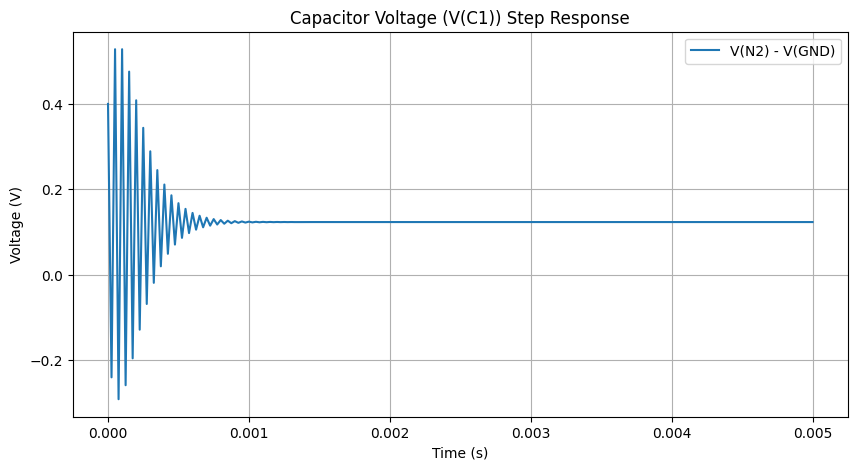

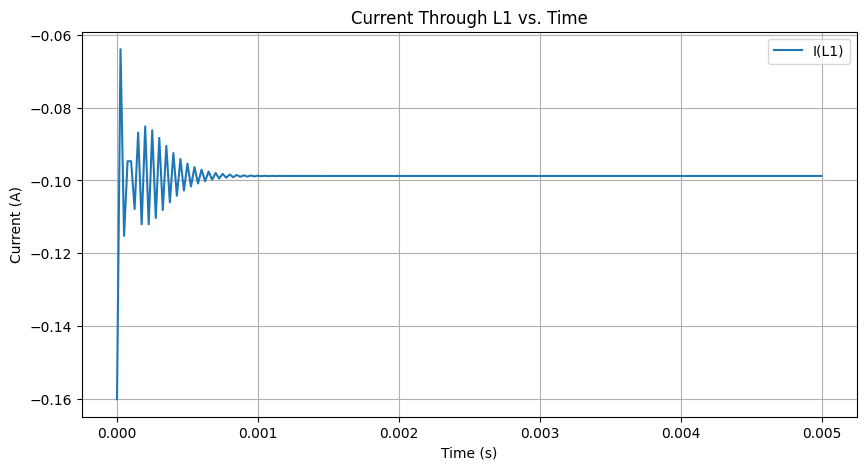

In [107]:
# BLOCK 8: RLC Filter Plot Results
print("\n=== BLOCK 8: RLC Filter Plot Results ===")
# Plot capacitor voltage (V(N2) - V(GND)) - This shows the output of the series circuit.
rlc_analysis.plot_voltage_difference('N2', 'GND', title="Capacitor Voltage (V(C1)) Step Response")
# Plot inductor current (I(L1)) - The current is the same through all series components.
rlc_analysis.plot_component_current(rlc_circuit, 'L1')